# A4 - 量子イジング模型

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/ja/A004-QuantumSystem.ipynb)

この章では量子 (主に横磁場)効果の入ったイジング模型をご紹介します。  
まずはGraphを定義し、$J_{ij}, h_i$を決定しておきましょう。

In [1]:
import cxxjij.graph as G
#問題サイズを100とします。
N = 100

graph = G.Dense(N)

In [2]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        #Jijの値が大きくなりすぎてしまうので、全体の係数を1/Nしています。
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

グラフの設定方法は前章と同じです。

## システムの設定 横磁場イジング模型

今回はシステムに横磁場イジング模型

\begin{align}
H &= s \left(\sum_{i<j}J_{ij}\sigma_i^z \sigma_j^z + \sum_{i=1}^{N}h_i \sigma_i^z \right) - \sum_{i=1}\Gamma (1-s) \sigma_i^x \\
\end{align}

を用います。

$\Gamma$は固定されたまま、$\beta$、$s$を変化させて量子モンテカルロ法を行います。
デフォルトでは鈴木・トロッター分解による量子モンテカルロ法が実装されています。

> 連続虚時間量子モンテカルロ法も用意してはいますが、現在試験的実装となっています。

まずはシステムを生成してみます。`system.make_transverse_ising`で生成できます。

In [3]:
import cxxjij.system as S

mysystem = S.make_transverse_ising(graph.gen_spin(), graph, 1.0, 4)

ここで、1つ目の引数にはスピン列を、2つ目にはグラフ、3つ目には$\Gamma$の値、4つ目にはtrotterスライスの数を入力します。
これで、全てのtrotterスライスが `graph.gen_spin()`で初期化されたシステムができます。

`mysystem.trotter_spins`で全てのtrotterスピンを表示します。縦方向が空間方向、横方向がtrotter方向です。
全てのtrotterスライスが同じスピンで初期化されていることがわかります。

In [4]:
print(mysystem.trotter_spins)

[[-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1

> `graph.gen_spin()`の代わりに上の二重Listを入れて直接trotterスピンを初期化することができます。

## アルゴリズムの実行 -Updater, Algorithm-

### Updater

量子モンテカルロ法に対しては、現状

* SingleSpinFlip (メトロポリス・ヘイスティング法によるスピン1つずつのアップデート)

が使用可能です。

### Algorithm

#### スケジュールリスト

スケジュールリストは`(パラメータ, モンテカルロステップ数)`のリストで与えられ、横磁場イジングモデルに対しては(($\beta$, $s$), モンテカルロステップ数)で与えます。例として以下のように設定してみましょう。

In [5]:
schedule_list = [((10, 0.1), 10),((12, 0.3), 80),((10, 0.8), 30)]

この場合、逆温度$\beta=10, s=0.1$で10モンテカルロステップ、$\beta=12, s=0.3$で80ステップ、$\beta=0.1, s=0.8$で30ステップの計120モンテカルロステップを実行することを意味します。  
アニーリングを実行するにあたっては、以下のように`utility`にある`make_transeverse_field_schedule_list`を使うとより便利です。

In [6]:
import cxxjij.utility as U
schedule_list = U.make_transverse_field_schedule_list(10, 20, 10)
print(schedule_list)

[((beta: 10.000000, s: 0.000000) mcs: 20), ((beta: 10.000000, s: 0.111111) mcs: 20), ((beta: 10.000000, s: 0.222222) mcs: 20), ((beta: 10.000000, s: 0.333333) mcs: 20), ((beta: 10.000000, s: 0.444444) mcs: 20), ((beta: 10.000000, s: 0.555556) mcs: 20), ((beta: 10.000000, s: 0.666667) mcs: 20), ((beta: 10.000000, s: 0.777778) mcs: 20), ((beta: 10.000000, s: 0.888889) mcs: 20), ((beta: 10.000000, s: 1.000000) mcs: 20)]


上の例では$\beta=10$で固定しながら$s=0$から$s=1$まで、各パラメータで20モンテカルロステップ計算しながら10段階で$s$を変えていく設定例です。計200モンテカルロステップの計算を行います。
$s$の変化については[Morita, Nishimori (2008)](https://aip.scitation.org/doi/10.1063/1.2995837)の手法を適用しています。

#### Algorithmの実行

続いて、Algorithmを実行します。前章と全く同じように書けます。

In [7]:
import cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

前章と同じようにcallbackを使ってみましょう。横磁場イジング模型の場合は、システムとパラメータ (逆温度$\beta$、$s$)を引数を持つ関数を作成すれば良いです。  
例として、以下ではシステムのエネルギーの値を記録するcallbackを作っています。

In [8]:
energies = []

def callback_log_energy(system, t):
    #graphは以前にGraphモジュールにて定義したオブジェクトです
    #各trotterスライスの平均値から、古典スピンの0、1を決めます。
    classical_spin = [-1 if np.mean(s)<0 else 1 for s in system.trotter_spins[:-1]] #最後のスピンは補助スピンのため、除く
    energies.append(graph.calc_energy(classical_spin))

このcallbackを用いて同じAlgorithmを実行します。

In [9]:
#スケジュールをもっと長く取ります (計20000モンテカルロステップ)
schedule_list = U.make_transverse_field_schedule_list(10, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

記録したシステムのエネルギーを、横軸をモンテカルロステップ、縦軸をエネルギーでプロットすると次のようになります。

In [ ]:
!pip install matplotlib

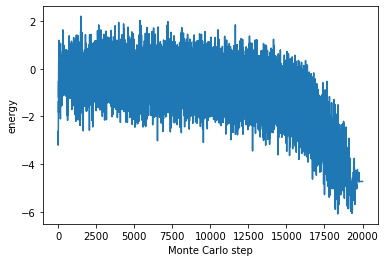

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

## 結果の取得 -Result-

`result.get_solutions`で計算結果である古典スピンを取得します。この関数は最適化問題を解く観点にフォーカスを当てているため、trotterスライスの中でもっともエネルギーが低いスピン列を返します。

In [11]:
import cxxjij.result as R
print(R.get_solution(mysystem))

[1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1]


## C++ core interface

```cpp
#include <graph/all.hpp>
#include <system/all.hpp>
#include <updater/all.hpp>
#include <algorithm/all.hpp>
#include <result/all.hpp>
#include <utility/schedule_list.hpp>
#include <utility/random.hpp>
#include <random>

#include <iostream>

using namespace openjij;

int main(void){

    //generate dense graph with size N=100
    constexpr std::size_t N = 100;
    auto dense = graph::Dense<double>(N);

    //generate random engine
    auto rand_engine = std::mt19937(0x1234);
    //of course you can specify another random generator that is compatible with C++ random generator, say utility::Xorshift,
    //auto rand_engine = utility::Xorshift(0x1234);

    //Gaussian distribution
    auto gauss = std::normal_distribution<>{0, 1};

    //set interactions
    for(std::size_t i=0; i<N; i++){
        for(std::size_t j=0; j<N; j++){
            dense.J(i, j) = (i == j) ? 0 : gauss(rand_engine)/N;
        }
    }

    //set local fields
    for(std::size_t i=0; i<N; i++){
        dense.h(i) = gauss(rand_engine);
    }

    //create transverse Ising system
    auto system = system::make_transverse_ising(dense.gen_spin(rand_engine), dense, 1.0, 4);

    //generate schedule list
    auto schedule_list = utility::make_transverse_field_schedule_list(10, 20, 10);

    //do annealing (updater: SingleSpinFlip)
    algorithm::Algorithm<updater::SingleSpinFlip>::run(system, rand_engine, schedule_list);

    //show spins
    std::cout << "The result spins are [";
    for(auto&& elem : result::get_solution(system)){
        std::cout << elem << " ";
    }

    std::cout << "]" << std::endl;
}
```